In [12]:
import spikeinterface.full as si
import probeinterface as pif
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import os


In [13]:
from probeinterface import plotting as pplot

In [ ]:
%matplotlib widget

Text(0.5, 1.0, 'NPX 1')

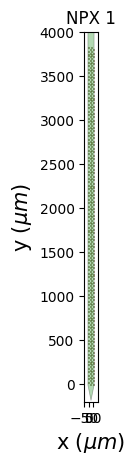

In [17]:
# path to meta file
meta_filename = 'D://NPX_Data//M388-2023-11-20_2_g0//M388-2023-11-20_2_g0_imec0//M388-2023-11-20_2_g0_tcat.imec0.ap.meta'
probe = pif.read_spikeglx(meta_filename)
fig,ax = plt.subplots()
pplot.plot_probe(probe, ax=ax)
ax.set_ylim([-200, 4000])
ax.set_title('NPX 1')

In [19]:
raw_rec = si.read_spikeglx('D://NPX_Data//M388-2023-11-20_2_g0//M388-2023-11-20_2_g0_imec0', \
                           stream_name='imec0.ap')
# non_neuronal = si.read_spikeglx(npx_path, stream_name='nidq', all_annotations=True)
# Turns out only the the analog streams are read from thhe .nidq file, and not the digital events.

In [20]:
rec1 = si.highpass_filter(raw_rec, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
print('bad_channel_ids, channel_labels')
for bad_channel_id in bad_channel_ids:
    index = int(bad_channel_id.split('AP')[1])
    print('{}, {}'.format(bad_channel_id, channel_labels[index]))

bad_channel_ids, channel_labels
imec0.ap#AP191, dead
imec0.ap#AP364, out
imec0.ap#AP365, out
imec0.ap#AP366, out
imec0.ap#AP367, out
imec0.ap#AP368, out
imec0.ap#AP369, out
imec0.ap#AP370, out
imec0.ap#AP371, out
imec0.ap#AP372, out
imec0.ap#AP373, out
imec0.ap#AP374, out
imec0.ap#AP375, out
imec0.ap#AP376, out
imec0.ap#AP377, out
imec0.ap#AP378, out
imec0.ap#AP379, out
imec0.ap#AP380, out
imec0.ap#AP381, out
imec0.ap#AP382, out
imec0.ap#AP383, out


In [21]:
#Remove bad channels after crosschecking with SpikeGLX viewer
rec1 = rec1.remove_channels(bad_channel_ids)
np.shape(rec1.get_channel_locations())

(363, 2)

# **Kilosort requires a binary file as input so the code below does that**

In [22]:
ks_working_folder = 'E://Temp'
# Make sure it exits and is in on the fastest memory drive
os.path.exists(ks_working_folder)

True

In [23]:
# Run this only if binary recording hasn't been written yet
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
rec = rec1.save(folder=os.path.join(ks_working_folder,'preprocess'), format='binary', **job_kwargs)

write_binary_recording with n_jobs = 40 and chunk_size = 30000


write_binary_recording:   0%|          | 0/1592 [00:00<?, ?it/s]

## **Run this only if the binary recording has already been written and progress was lost after that step**

In [14]:
# Number of good channels
gc = 363;
rec = si.BinaryRecordingExtractor('/ks2_t/preprocess/traces_cached_seg0.raw', 30000, 'int16', gc) 
# Hacky Steps because Binary recordings does not contain the following properties
rec.set_channel_locations(rec1.get_channel_locations())
rec.set_probe(rec1.get_probe())
rec.set_property('contact_vector', rec1.get_property('contact_vector'))
rec.annotate(is_filtered=True)

In [ ]:
# check manually for drifts (Straight lines are good, slanting lines indeicate drift)
rec2 = si.common_reference(rec1, operator="median", reference="global")
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(rec2,  method='locally_exclusive',
                     detect_threshold=5, **job_kwargs)
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peak_locations = localize_peaks(rec2, peaks, method='center_of_mass', **job_kwargs)

fs = rec2.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.', alpha=0.002)

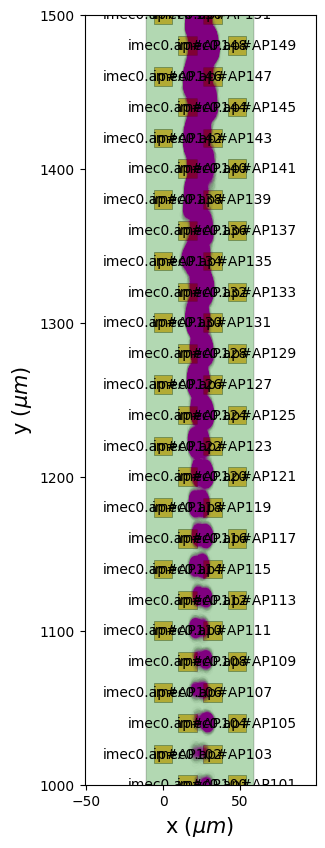

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))
si.plot_probe_map(rec, ax=ax, with_channel_ids=True)
ax.set_ylim(1000, 1500)

ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

In [24]:
ks2_path = 'C://Users//mvdmlab/Documents//GitHub//Kilosort-2.5'
si.Kilosort2_5Sorter.set_kilosort2_5_path(ks2_path)
si.Kilosort2_5Sorter.is_installed() # Should return true, if not change path accordingly

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: C:\Users\mvdmlab\Documents\GitHub\Kilosort-2.5


True

In [25]:
ks2_5_params = si.get_default_sorter_params('kilosort2_5')
print(ks2_5_params)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'nblocks': 5, 'sig': 20, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'do_correction': True, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': ('matlab_files',), 'delete_recording_dat': False, 'n_jobs': 16, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}


In [26]:
sorting = si.run_sorter('kilosort2_5', rec, output_folder=os.path.join(ks_working_folder, 'ks2_output'),
                        verbose=True, remove_existing_folder=False, **ks2_5_params)

RUNNING SHELL SCRIPT: E:\Temp\ks2_output\sorter_output\run_kilosort2_5.bat


C:\Users\mvdmlab\Documents\mbl_mouse_2023\student_and_instructor_code\manish\python_stuff>E:



E:\>cd E:\Temp\ks2_output\sorter_output 



E:\Temp\ks2_output\sorter_output>matlab -nosplash -wait -r "kilosort2_5_master('E:\Temp\ks2_output\sorter_output', 'C:\Users\mvdmlab\Documents\GitHub\Kilosort-2.5')" 

kilosort2_5 run time 1191.49s


In [30]:
# job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
# we = si.extract_waveforms(rec, sorting, folder=os.path.join(ks_working_folder, 'si_waveforms'), ms_before=1.5, ms_after=2.5, max_spikes_per_unit=1000, **job_kwargs)
# Change the above line if more spikes are needed or if the waveform length needs to be different



Setting 'return_scaled' to False


extract waveforms memmap:   0%|          | 0/1592 [00:00<?, ?it/s]

In [ ]:
# This is a super long time taking step, not sure in what case it is needed
# si.export_to_phy(we, os.path.join(ks_working_folder, 'si_phy'), **job_kwargs)

/opt/anaconda/envs/spikeinterface/lib/python3.9/site-packages/spikeinterface/exporters/to_phy.py:85: UserWarning: Exporting to Phy with many channels and without sparsity might result in a heavy and less informative visualization. You can use use a sparse WaveformExtractor or you can use the 'sparsity' argument to enforce sparsity (see compute_sparsity())
  warnings.warn(


write_binary_recording:   0%|          | 0/1592 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract amplitudes:   0%|          | 0/1592 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/229 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/229 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/1592 [00:00<?, ?it/s]

# LFP analysis (TBD)

In [ ]:
# lfp.get_property_keys()

In [ ]:
# bad_channel_ids, channel_labels = si.detect_bad_channels(lfp)

In [ ]:
# lfp2 = si.phase_shift(lfp)
# lfp3 = si.common_reference(lfp2, operator="median", reference="global") # obviously wrong thing to do

# # here we use static plot using matplotlib backend
# fig, axs = plt.subplots(ncols=3, figsize=(20, 10))

# si.plot_timeseries(lfp, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
# si.plot_timeseries(lfp2, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
# si.plot_timeseries(lfp3, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
# for i, label in enumerate(('original', 'phase_shift', 'final')):
#     axs[i].set_title(label)
    
# plt.show()